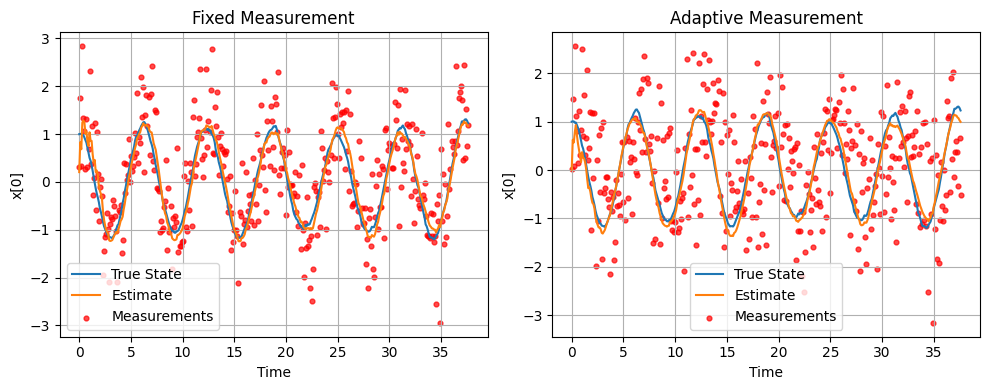

In [14]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Generate the "true" system trajectory + measurement noise
# ------------------------------------------------------------

def generate_data(periods=6, dt=0.1, omega=1.0, Q_scale=0.005, R_val=0.5, seed=42):
    """
    Generates:
      - x_true: shape (time_steps, 2), the "true" states of the system
                with process noise added at each step
      - A:      2x2 matrix = expm(A_euler)
      - Q:      2x2 process noise covariance
      - R_val:  scalar measurement noise variance
      - measurement_noises: shape (time_steps,), one noise sample per step

    The idea is to keep the same x_true and measurement_noises for
    both fixed and adaptive filters, so they see the *exact same* random draws.
    """
    np.random.seed(seed)  # reproducible
    
    # 1) Define system matrix A
    A_euler = np.array([[0, dt],
                        [-omega**2 * dt, 0]])
    A = scipy.linalg.expm(A_euler)  # discrete-time transition
    Q = np.eye(2) * Q_scale * dt    # process noise covariance
    
    # 2) Number of time steps
    time_steps = round(periods * 2 * np.pi / dt)
    
    # 3) Generate "true" states with process noise
    x_true = np.zeros((time_steps, 2))
    x_true[0] = [1.0, 0.0]  # initial condition
    for k in range(time_steps - 1):
        w_k = np.random.multivariate_normal([0, 0], Q)
        x_true[k+1] = A @ x_true[k] + w_k
    
    # 4) Generate measurement noises (one per step)
    #    We'll reuse these for *both* filters.
    measurement_noises = np.random.normal(0, np.sqrt(R_val), size=time_steps)
    
    return x_true, A, Q, R_val, measurement_noises, dt

# ------------------------------------------------------------
# 2. Kalman Predict/Update + principal eigenvector
# ------------------------------------------------------------

def kalman_predict(x_est, P_est, A, Q):
    x_pred = A @ x_est
    P_pred = A @ P_est @ A.T + Q
    return x_pred, P_pred

def kalman_update(x_pred, P_pred, y, m, R):
    y_pred = m @ x_pred
    innovation = y - y_pred
    S = m @ P_pred @ m + R  # scalar
    K = (P_pred @ m) / S    # shape (2,)
    x_est = x_pred + K * innovation
    P_est = P_pred - np.outer(K, m) @ P_pred
    return x_est, P_est

def principal_eigenvector(P):
    vals, vecs = np.linalg.eig(P)
    idx = np.argmax(vals)
    v = vecs[:, idx]
    return v / np.linalg.norm(v)

# ------------------------------------------------------------
# 3. Run Kalman: Fixed vs. Adaptive, reusing same data
# ------------------------------------------------------------

def run_kalman_fixed(x_true, A, Q, R_val, measurement_noises):
    """
    Uses m = [1, 0] at each step, reusing the same measurement_noises
    so that measurement_noises[k] is the random part of y_k.
    """
    time_steps = x_true.shape[0]
    x_est = np.array([0.0, 0.0])
    P_est = np.eye(2) * 1.0
    
    x_est_array = np.zeros((time_steps, 2))
    measurements = np.zeros(time_steps)
    
    for k in range(time_steps):
        # Predict
        x_pred, P_pred = kalman_predict(x_est, P_est, A, Q)
        
        # True state at step k
        xk_true = x_true[k]
        
        # Generate measurement: same noise draw, but direction = [1,0]
        m = np.array([1.0, 0.0])
        y = m @ xk_true + measurement_noises[k]
        
        # Update
        x_est, P_est = kalman_update(x_pred, P_pred, y, m, R_val)
        
        x_est_array[k] = x_est
        measurements[k] = y
    
    return x_est_array, measurements

def run_kalman_adaptive(x_true, A, Q, R_val, measurement_noises):
    """
    Uses m = principal_eigenvector(P_pred) each step, reusing the same
    measurement_noises.  So measurement_noises[k] is the random part of y_k.
    """
    time_steps = x_true.shape[0]
    x_est = np.array([0.0, 0.0])
    P_est = np.eye(2) * 1.0
    
    x_est_array = np.zeros((time_steps, 2))
    measurements = np.zeros(time_steps)
    
    for k in range(time_steps):
        # Predict
        x_pred, P_pred = kalman_predict(x_est, P_est, A, Q)
        
        # True state at step k
        xk_true = x_true[k]
        
        # Adaptive measurement direction
        m = principal_eigenvector(P_pred)
        
        # Generate measurement using the *same* noise draw as the fixed approach
        y = m @ xk_true + measurement_noises[k]
        
        # Update
        x_est, P_est = kalman_update(x_pred, P_pred, y, m, R_val)
        
        x_est_array[k] = x_est
        measurements[k] = y
    
    return x_est_array, measurements

# ------------------------------------------------------------
# 4. Main: Generate data once, run both filters, compare
# ------------------------------------------------------------

def main():
    # 1) Generate system + data
    #    We'll fix the random seed so both methods see the same process noise
    #    and the same measurement noise draws (just used differently).
    x_true, A, Q, R_val, measurement_noises, dt = generate_data(
        periods=6, dt=0.1, omega=1.0, Q_scale=0.005, R_val=0.5, seed=42
    )
    
    time_steps = x_true.shape[0]
    time_array = np.arange(time_steps) * dt
    
    # 2) Run Kalman with fixed measurement
    x_est_fixed, meas_fixed = run_kalman_fixed(x_true, A, Q, R_val, measurement_noises)
    
    # 3) Run Kalman with adaptive measurement
    x_est_adaptive, meas_adaptive = run_kalman_adaptive(x_true, A, Q, R_val, measurement_noises)


 
    
    # 4) Plot
    plt.figure(figsize=(10,4))
    
    # Left: Fixed
    plt.subplot(1,2,1)
    plt.plot(time_array, x_true[:,0], label="True State")
    plt.plot(time_array, x_est_fixed[:,0], label="Estimate")
    plt.scatter(time_array, meas_fixed, s=12, color='r', alpha=0.7, label="Measurements")
    plt.title("Fixed Measurement")
    plt.xlabel("Time")
    plt.ylabel("x[0]")
    plt.grid(True)
    plt.legend()
    
    # Right: Adaptive
    plt.subplot(1,2,2)
    plt.plot(time_array, x_true[:,0], label="True State")
    plt.plot(time_array, x_est_adaptive[:,0], label="Estimate")
    plt.scatter(time_array, meas_adaptive, s=12, color='r', alpha=0.7, label="Measurements")
    plt.title("Adaptive Measurement")
    plt.xlabel("Time")
    plt.ylabel("x[0]")
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


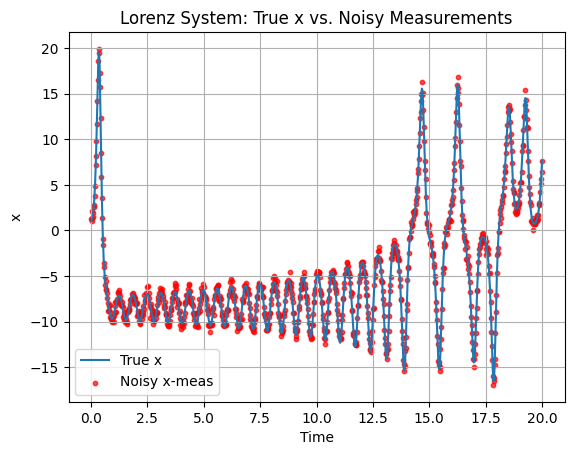

In [15]:
import numpy as np
import scipy.linalg
from scipy.integrate import solve_ivp

def generate_lorenz_data(sigma=10.0, rho=28.0, beta=8/3,
                         dt=0.02, t_end=20.0, x0=[1.0, 1.0, 1.0],
                         R_val=0.2, seed=42):
    """
    Generates a Lorenz trajectory by numerically integrating the ODE,
    then adds measurement noise for observations of (x, y).

    :param sigma, rho, beta: Lorenz system parameters.
    :param dt: time step for the solver output.
    :param t_end: end time.
    :param x0: initial condition [x, y, z].
    :param R_val: measurement noise variance for each of x, y.
    :param seed: random seed for reproducibility.

    :return:
      time_span: array of time points of length N.
      true_states: shape (N, 3), the solution of the Lorenz system [x, y, z].
      measurements: shape (N, 2), noisy measurements of [x, y].
    """
    np.random.seed(seed)

    # Define the Lorenz system
    def lorenz_system(t, state):
        x, y, z = state
        dxdt = sigma * (y - x)
        dydt = x * (rho - z) - y
        dzdt = x * y - beta * z
        return [dxdt, dydt, dzdt]

    # Build the time array and solve the ODE
    N = round(t_end / dt)
    time_span = np.linspace(0, t_end, N)
    sol = solve_ivp(lorenz_system, [time_span[0], time_span[-1]], x0, t_eval=time_span)

    # True states: shape (N, 3) after transposing sol.y (which is (3, N))
    true_states = sol.y.T

    # Measurement noise covariance R (2x2). We measure (x, y) only.
    R = np.eye(2) * R_val

    # Generate measurement noise. We draw N samples from N(0, R).
    # shape: (N,2). Then we multiply by sqrtm(R).T for correlated if needed.
    noise = np.random.normal(0, 1, (N, 2)) @ scipy.linalg.sqrtm(R).T

    # Observations: H = [[1, 0, 0],
    #                    [0, 1, 0]]
    # so we take (x, y) from the true states and add noise
    measurements = true_states[:, :2] + noise

    return time_span, true_states, measurements


# ------------------------------------------------------
# Example usage:
if __name__ == "__main__":
    # Generate Lorenz data
    t_array, X_true, Y_meas = generate_lorenz_data(
        sigma=10, rho=28, beta=8/3,
        dt=0.02, t_end=20,
        x0=[1,1,1],
        R_val=0.2,
        seed=42
    )

    # Plot the first coordinate (x) vs. time
    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(t_array, X_true[:,0], label='True x')
    plt.scatter(t_array, Y_meas[:,0], s=10, color='r', alpha=0.7, label='Noisy x-meas')
    plt.title("Lorenz System: True x vs. Noisy Measurements")
    plt.xlabel("Time")
    plt.ylabel("x")
    plt.legend()
    plt.grid(True)
    plt.show()
